<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/Test_API_VNQuant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thử nghiệm thư viện vnquant để đồng bộ dữ liệu và xây dựng mô hình dự đoán giá chứng khoán

Model sử dụng tensorflow: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
!pip install git+https://github.com/phamdinhkhanh/vnquant

  Cloning https://github.com/phamdinhkhanh/vnquant to /tmp/pip-req-build-xwx2msce
  Running command git clone -q https://github.com/phamdinhkhanh/vnquant /tmp/pip-req-build-xwx2msce
     |████████████████████████████████| 6.3MB 6.7MB/s 
  Created wheel for vnquant: filename=vnquant-0.0.2-cp37-none-any.whl size=9886 sha256=03b1c3696c0f6ba2e70ec6075306a8c87c0db5e3a16533b7c30612ad75538b94
  Stored in directory: /tmp/pip-ephem-wheel-cache-hfyii9ng/wheels/70/f7/51/ab84791f03861a32e07cb59321d8911fb994eee39e08f2b77b
  Created wheel for pypandoc: filename=pypandoc-1.5-cp37-none-any.whl size=17036 sha256=216dcb868e6c24dcc141ff66509f3bf05b397fe2ec034b278a3655a3bc70b7ec
  Stored in directory: /root/.cache/pip/wheels/bb/7d/d6/2f9af55e800d37e42e546106bcbd36a86e24e725e303d17e04
Successfully built vnquant pypandoc
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import vnquant.DataLoader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [129]:
loader = web.DataLoader('HPG', '2018-02-02','2021-05-28', data_source='VND')
data = loader.download()
data.head()

2021-05-31 16:49:04,890 : INFO : data HPG from 2018-02-02 to 2021-05-28 have already cloned!


Attributes,high,low,open,close,avg,volume
Symbols,HPG,HPG,HPG,HPG,HPG,HPG
date,,,,,,
2018-02-02,61.4,59.7,61.0,61.1,60.48,3891320.0
2018-02-05,60.4,57.0,59.9,57.0,58.59,7357220.0
2018-02-06,59.4,53.1,53.1,58.0,54.22,14973300.0
2018-02-07,61.5,59.1,60.5,59.5,60.44,7438850.0
2018-02-08,60.8,58.8,59.5,59.7,59.77,4683450.0


In [130]:
data.columns = ['high', 'low', 'open', 'close', 'avg', 'volumne']

In [131]:
data['stdev'] = data[['high', 'low', 'open', 'close']].apply(lambda x: np.std(x), axis = 1)
data.head()

,high,low,open,close,avg,volumne,stdev
date,,,,,,,
2018-02-02,61.4,59.7,61.0,61.1,60.48,3891320.0,0.651920
2018-02-05,60.4,57.0,59.9,57.0,58.59,7357220.0,1.584890
2018-02-06,59.4,53.1,53.1,58.0,54.22,14973300.0,2.843413
2018-02-07,61.5,59.1,60.5,59.5,60.44,7438850.0,0.931397
2018-02-08,60.8,58.8,59.5,59.7,59.77,4683450.0,0.717635


TỰ WINDOWING

In [132]:
rnum = data.shape[0]
df = data

In [133]:
# Xử dụng dữ liệu trong 60 ngày, dự đoán giá trong 15 ngày tiếp theo
def get_cursor_change(data, point_index, cycle):
  start = data.iloc[(point_index - cycle),:]
  end = data.iloc[point_index,:]
  return (end - start )/start #pd.concat([(end - start )/start, data.iloc[(point_index - cycle):point_index, :].mean() ])

def get_features(data, point_index ):
  ft_7d = get_cursor_change( data, point_index, 7)
  ft_14d = get_cursor_change( data, point_index, 14)
  ft_30d = get_cursor_change( data, point_index, 30)
  ft_60d = get_cursor_change( data, point_index, 60)
  features = pd.concat([ft_7d, ft_14d, ft_30d, ft_60d])
  features.index = [i+t for t in ['_7d', '_14d', '_30d', '_60d'] for i in ft_7d.index]
  return features

def get_features_and_label(data, point_index, label = 'close'):
  features = get_features(data, point_index)

  labels = get_cursor_change(data[[label]], point_index+ 10, 10)
  labels.index = [label+'_add_10d']

  return pd.concat([features, labels])

def get_infer_dataset(data):
  series = []
  for i in range(data.shape[0]):
    try: 
      series.append(get_features(data, i))
    except: pass
  return pd.concat(series, axis = 1).T

def get_training_dataset(data):
  train_series = []
  indices = []
  for i in range(data.shape[0]-60):
    point_index = i+60
    try:
      train_series.append(get_features_and_label( data, point_index ))
      indices.append(data.iloc[point_index].name)
    except: pass
  out_data = pd.concat(train_series, axis = 1).T
  out_data.index = indices
  return out_data


In [134]:
df_windowed = get_training_dataset( df)

In [135]:
df_windowed

,high_7d,low_7d,open_7d,close_7d,avg_7d,volumne_7d,stdev_7d,high_14d,low_14d,open_14d,close_14d,avg_14d,volumne_14d,stdev_14d,high_30d,low_30d,open_30d,close_30d,avg_30d,volumne_30d,stdev_30d,high_60d,low_60d,open_60d,close_60d,avg_60d,volumne_60d,stdev_60d,close_add_10d
2018-05-09,0.012324,0.056497,0.014286,0.065421,0.044077,-0.510759,-0.682354,-0.057377,-0.066556,-0.061157,-0.051581,-0.059242,0.020939,0.358215,-0.072581,-0.072727,-0.061157,-0.071661,-0.072140,-0.584489,-0.210407,-0.063518,-0.060302,-0.068852,-0.067103,-0.060020,-0.394432,-0.229210,-0.092982
2018-05-10,0.053704,0.061776,0.059813,0.026022,0.060011,-0.468717,-0.016234,-0.057947,-0.067797,-0.061258,-0.075377,-0.059129,-0.252997,0.474584,-0.071778,-0.059829,-0.065898,-0.062818,-0.059759,-0.792910,-0.273414,-0.057947,-0.035088,-0.053422,-0.031579,-0.041304,-0.629182,-0.459986,-0.050725
2018-05-11,0.007220,0.022514,0.003676,0.023897,0.015257,-0.383876,-0.189536,-0.073090,-0.076271,-0.088481,-0.055932,-0.073167,-0.010523,0.124107,-0.068447,-0.069966,-0.068259,-0.062290,-0.066272,-0.529385,0.086859,-0.060606,0.026365,0.028249,-0.039655,0.018628,-0.817758,-0.788255,-0.064632
2018-05-14,0.033028,0.029963,0.033149,0.027624,0.031331,-0.557497,0.160637,-0.047377,-0.035088,-0.042662,-0.021053,-0.043994,-0.421318,-0.474404,-0.064784,-0.064626,-0.055556,-0.068447,-0.064413,0.228752,-0.067702,-0.084553,-0.069374,-0.072727,-0.062185,-0.079583,-0.601823,-0.468567,-0.127240
2018-05-15,0.016275,0.024119,0.020073,0.025926,0.023718,-0.688939,-0.315688,-0.044218,-0.017794,-0.019298,-0.057823,-0.029796,-0.186473,-0.651276,-0.081699,-0.076923,-0.068333,-0.088816,-0.078298,-0.386587,-0.307896,-0.075658,-0.061224,-0.060504,-0.072027,-0.068429,-0.427174,-0.448084,-0.061372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,0.122340,0.117647,0.103448,0.119005,0.133814,0.213965,0.407593,0.157221,0.158095,0.136449,0.155963,0.168370,-0.109919,0.344481,0.365696,0.348115,0.320304,0.386139,0.374208,0.191314,1.405862,0.494687,0.482927,0.475728,0.500000,0.510572,-0.201322,1.121618,0.038095
2021-05-11,0.120354,0.117117,0.124334,0.107143,0.116777,0.802274,0.725681,0.136445,0.158879,0.170055,0.135531,0.149569,0.035886,-0.194935,0.383607,0.383929,0.385120,0.377778,0.380040,0.455430,0.551720,0.500000,0.492178,0.507143,0.483254,0.496059,0.274261,1.699705,0.087097
2021-05-12,0.068143,0.086879,0.090265,0.079174,0.068327,0.130305,-0.365071,0.084775,0.120658,0.115942,0.084775,0.098541,-0.095262,-0.558517,0.357143,0.360710,0.353846,0.357143,0.351718,0.077561,0.296128,0.468384,0.470024,0.468415,0.475294,0.462467,0.277200,0.570339,0.081340
2021-05-13,0.043046,0.078947,0.089005,0.028428,0.067422,-0.158249,-0.574017,0.075085,0.098214,0.075862,0.075175,0.087572,-0.275563,-0.346211,0.351931,0.332611,0.341935,0.328294,0.342974,1.019059,2.645862,0.478873,0.537500,0.468235,0.503667,0.512764,-0.165142,-0.420259,0.086179


In [136]:
split = int(df_windowed.shape[0]*0.7)
train_df = df_windowed.iloc[:split]
valid_df = df_windowed.iloc[split:]

In [137]:
train_df

,high_7d,low_7d,open_7d,close_7d,avg_7d,volumne_7d,stdev_7d,high_14d,low_14d,open_14d,close_14d,avg_14d,volumne_14d,stdev_14d,high_30d,low_30d,open_30d,close_30d,avg_30d,volumne_30d,stdev_30d,high_60d,low_60d,open_60d,close_60d,avg_60d,volumne_60d,stdev_60d,close_add_10d
2018-05-09,0.012324,0.056497,0.014286,0.065421,0.044077,-0.510759,-0.682354,-0.057377,-0.066556,-0.061157,-0.051581,-0.059242,0.020939,0.358215,-0.072581,-0.072727,-0.061157,-0.071661,-0.072140,-0.584489,-0.210407,-0.063518,-0.060302,-0.068852,-0.067103,-0.060020,-0.394432,-0.229210,-0.092982
2018-05-10,0.053704,0.061776,0.059813,0.026022,0.060011,-0.468717,-0.016234,-0.057947,-0.067797,-0.061258,-0.075377,-0.059129,-0.252997,0.474584,-0.071778,-0.059829,-0.065898,-0.062818,-0.059759,-0.792910,-0.273414,-0.057947,-0.035088,-0.053422,-0.031579,-0.041304,-0.629182,-0.459986,-0.050725
2018-05-11,0.007220,0.022514,0.003676,0.023897,0.015257,-0.383876,-0.189536,-0.073090,-0.076271,-0.088481,-0.055932,-0.073167,-0.010523,0.124107,-0.068447,-0.069966,-0.068259,-0.062290,-0.066272,-0.529385,0.086859,-0.060606,0.026365,0.028249,-0.039655,0.018628,-0.817758,-0.788255,-0.064632
2018-05-14,0.033028,0.029963,0.033149,0.027624,0.031331,-0.557497,0.160637,-0.047377,-0.035088,-0.042662,-0.021053,-0.043994,-0.421318,-0.474404,-0.064784,-0.064626,-0.055556,-0.068447,-0.064413,0.228752,-0.067702,-0.084553,-0.069374,-0.072727,-0.062185,-0.079583,-0.601823,-0.468567,-0.127240
2018-05-15,0.016275,0.024119,0.020073,0.025926,0.023718,-0.688939,-0.315688,-0.044218,-0.017794,-0.019298,-0.057823,-0.029796,-0.186473,-0.651276,-0.081699,-0.076923,-0.068333,-0.088816,-0.078298,-0.386587,-0.307896,-0.075658,-0.061224,-0.060504,-0.072027,-0.068429,-0.427174,-0.448084,-0.061372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11,-0.023381,-0.053803,-0.034173,-0.057301,-0.036264,0.998395,0.886303,-0.010929,-0.028571,0.018975,-0.064220,-0.019747,0.272877,0.426701,0.228507,0.200000,0.220455,0.191589,0.221448,1.959847,1.057983,0.367758,0.345646,0.398438,0.335079,0.359690,1.237354,1.203893,0.070588
2020-06-12,-0.025735,-0.078947,-0.094270,-0.016698,-0.058364,0.760989,3.529108,-0.046763,-0.097606,-0.109091,-0.029304,-0.076895,0.889980,3.109324,0.221198,0.166667,0.144860,0.232558,0.183092,1.852305,2.922323,0.373057,0.317204,0.317204,0.380208,0.329659,2.099375,2.058876,0.026415
2020-06-15,-0.032847,-0.046992,-0.025926,-0.045113,-0.040520,-0.218565,0.560795,-0.066901,-0.071429,-0.038391,-0.105634,-0.074247,-0.029957,-0.037438,0.229698,0.207143,0.223256,0.209524,0.217453,1.348258,0.967570,0.318408,0.310078,0.355670,0.289340,0.308824,-0.027128,0.733062,0.049213
2020-06-16,-0.032967,-0.020992,-0.018868,-0.031423,-0.029773,-0.335289,-0.363250,-0.076923,-0.056985,-0.090909,-0.036765,-0.068596,-0.551309,-0.604312,0.219400,0.204225,0.214953,0.224299,0.214252,0.542890,1.142145,0.353846,0.357143,0.340206,0.368146,0.363494,0.146688,0.189532,0.022901


In [138]:
train_df.shape

(529, 29)

In [139]:
cols_ft = [i for i in train_df.columns if i !='close_add_10d']
label = 'close_add_10d'

In [140]:
model = RandomForestRegressor(min_samples_leaf = 15, n_estimators=1000)

In [141]:
model.fit(train_df[ cols_ft ], train_df[label])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [142]:
# Train set evaluation
y_true = train_df[label]
y_pred = model.predict( train_df[cols_ft] )

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

0.4273963481622328
0.045798573504272355


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528
0,-0.092982,-0.050725,-0.064632,-0.127240,-0.061372,-0.022222,0.058491,0.057514,0.127820,0.168317,0.176015,0.181298,0.176583,0.244353,-0.182692,-0.178030,-0.240642,-0.245614,-0.330000,-0.350000,-0.342105,-0.365913,-0.331974,-0.315182,-0.032941,-0.089862,-0.088028,-0.106977,-0.044776,-0.053455,-0.072500,-0.080255,-0.101343,-0.139759,-0.136253,-0.129114,-0.131274,-0.072917,-0.075521,-0.005510,...,0.168317,0.125000,0.108796,0.070136,0.097950,0.119159,0.093023,0.195238,0.221963,0.191441,0.122881,0.164530,0.139875,0.200846,0.128631,0.135699,0.165957,0.101594,0.034417,0.018904,0.003774,-0.007339,0.014652,-0.045775,-0.007353,-0.062500,-0.032847,-0.081374,-0.031423,-0.025974,0.007519,0.011091,-0.014440,-0.003690,0.000000,0.070588,0.026415,0.049213,0.022901,0.043810
1,-0.074886,-0.052569,-0.049248,-0.069684,-0.049634,-0.064541,-0.032404,0.003874,0.032489,-0.003459,0.030647,0.039665,0.033134,0.024605,-0.040091,-0.036983,-0.056897,-0.084829,-0.089740,-0.068581,-0.072969,-0.075786,-0.051884,-0.071630,-0.003932,-0.043951,-0.026985,-0.026405,-0.017120,-0.012256,-0.019157,-0.033594,-0.033212,-0.037228,-0.044530,-0.037037,-0.048095,-0.041404,-0.013901,0.017573,...,0.070937,0.071739,0.081629,0.078278,0.052511,0.059141,0.061668,0.071827,0.066999,0.066137,0.033363,0.042156,0.039791,0.035383,0.041550,0.037374,0.036337,0.015549,-0.004466,0.021029,-0.012054,-0.017966,-0.015173,-0.017929,-0.016923,-0.006896,-0.003273,-0.001919,-0.003532,-0.000036,-0.000209,-0.016660,-0.003812,-0.004721,-0.006016,0.006217,-0.007567,-0.004361,-0.008814,0.006017
2,-0.018096,0.001845,-0.015384,-0.057556,-0.011738,0.042319,0.090894,0.053640,0.095330,0.171776,0.145368,0.141633,0.143449,0.219749,-0.142602,-0.141047,-0.183744,-0.160785,-0.240260,-0.281419,-0.269137,-0.290127,-0.280089,-0.243551,-0.029009,-0.045911,-0.061044,-0.080571,-0.027656,-0.041199,-0.053343,-0.046661,-0.068131,-0.102531,-0.091723,-0.092077,-0.083180,-0.031513,-0.061620,-0.023083,...,0.097380,0.053261,0.027167,-0.008142,0.045439,0.060017,0.031355,0.123411,0.154963,0.125304,0.089519,0.122374,0.100083,0.165463,0.087081,0.098325,0.129620,0.086044,0.038883,-0.002125,0.015828,0.010627,0.029825,-0.027846,0.009570,-0.055604,-0.029574,-0.079455,-0.027891,-0.025938,0.007728,0.027751,-0.010629,0.001031,0.006016,0.064371,0.033982,0.053573,0.031715,0.037792
3,0.194622,-0.036363,0.238019,0.452340,0.191264,-1.904363,1.553997,0.932645,0.745821,1.020549,0.825882,0.781218,0.812358,0.899307,0.780557,0.792264,0.763560,0.654624,0.728062,0.804054,0.786707,0.792885,0.843709,0.772734,0.880640,0.510903,0.693455,0.753168,0.617642,0.770731,0.735763,0.581405,0.672279,0.733624,0.673181,0.713144,0.633632,0.432180,0.815937,4.189517,...,0.578550,0.426087,0.249707,-0.116088,0.463899,0.503676,0.337067,0.632103,0.698150,0.654531,0.728497,0.743777,0.715522,0.823831,0.676986,0.724582,0.781045,0.846947,1.129767,-0.112432,4.194405,-1.447887,2.035557,0.608324,-1.301550,0.889662,0.900358,0.976412,0.887586,0.998617,1.027805,2.502170,0.736043,-0.279341,inf,0.911920,1.286477,1.088613,1.384887,0.862652


In [143]:
# Valid set evaluation
y_true = valid_df[label]
y_pred = model.predict( valid_df[cols_ft] )

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

-0.8269078402994126
0.0799302564889024


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226
0,0.029851,0.005484,0.010989,0.050000,0.038889,0.031136,0.020221,0.037523,0.041045,0.023723,0.036232,0.038182,0.014493,-0.008818,0.001783,0.001776,-0.032432,-0.061483,-0.019713,-0.224599,-0.227273,-0.239930,-0.182143,-0.181495,-0.142349,-0.147163,-0.098696,-0.063584,-0.113346,0.117241,0.108597,0.110599,0.061135,0.050000,0.006224,0.002079,0.006198,0.020576,0.012371,-0.004115,...,0.010799,0.040773,0.040297,0.054545,0.060086,0.088009,0.096667,0.072511,0.105832,0.078579,0.132479,0.123711,0.113150,0.172414,0.157895,0.112235,0.142857,0.112008,0.099609,0.117764,0.096226,0.097248,0.086081,0.027682,0.062937,0.145455,0.099291,0.137931,0.092362,0.096429,0.065404,0.060201,0.114671,0.121212,0.078947,0.038095,0.087097,0.081340,0.086179,0.092834
1,-0.004446,-0.005603,-0.035504,-0.036983,-0.021749,-0.001121,-0.004067,-0.005565,-0.001576,0.000660,-0.022772,-0.008580,-0.036664,-0.032617,-0.022764,-0.038612,-0.000114,-0.007123,-0.008216,-0.007185,-0.016416,-0.031909,-0.011204,-0.006316,-0.004879,0.008828,-0.007795,-0.018243,-0.019572,-0.051971,-0.053750,-0.058530,-0.062757,-0.063646,-0.043668,-0.045147,-0.066998,-0.057053,-0.059104,-0.076876,...,-0.029298,-0.024169,0.005883,0.010311,0.011194,-0.004576,0.003266,-0.011465,0.011854,-0.003058,0.010308,-0.016377,-0.041623,-0.035202,-0.041387,-0.025445,-0.021835,-0.020788,-0.028410,-0.013353,-0.021476,-0.012880,-0.017638,-0.033207,-0.025268,-0.023107,-0.019599,-0.040351,-0.022817,-0.016264,-0.007082,-0.005769,-0.031130,-0.012540,-0.005727,0.000484,-0.013501,0.000798,-0.037027,-0.008285
2,0.034297,0.011088,0.046493,0.086983,0.060637,0.032257,0.024288,0.043089,0.042621,0.023063,0.059004,0.046762,0.051157,0.023798,0.024547,0.040388,-0.032318,-0.054360,-0.011497,-0.217414,-0.210856,-0.208021,-0.170939,-0.175179,-0.137469,-0.155991,-0.090902,-0.045341,-0.093774,0.169213,0.162347,0.169129,0.123892,0.113646,0.049892,0.047226,0.073196,0.077629,0.071475,0.072761,...,0.040098,0.064942,0.034414,0.044234,0.048892,0.092585,0.093400,0.083976,0.093977,0.081637,0.122171,0.140088,0.154773,0.207616,0.199282,0.137679,0.164692,0.132796,0.128019,0.131117,0.117702,0.110128,0.103719,0.060889,0.088205,0.168561,0.118890,0.178282,0.115179,0.112693,0.072487,0.065970,0.145801,0.133753,0.084674,0.037611,0.100598,0.080542,0.123206,0.101119
3,1.148933,2.021662,4.230847,1.739652,1.559249,1.036018,1.201140,1.148319,1.038400,0.972198,1.628500,1.224712,3.529818,-2.698745,13.770588,22.738681,0.996470,0.884142,0.583231,0.968009,0.927768,0.867008,0.938490,0.965201,0.965723,1.059985,0.921025,0.713091,0.827324,1.443286,1.494945,1.529212,2.026519,2.272928,8.016029,22.715781,11.809003,3.772775,5.777589,-17.680971,...,3.713037,1.592784,0.854015,0.810958,0.813699,1.051999,0.966211,1.158120,0.887989,1.038916,0.922194,1.132382,1.367859,1.204174,1.262117,1.226711,1.152847,1.185597,1.285212,1.113384,1.223182,1.132444,1.204903,2.199612,1.401481,1.158858,1.197391,1.292541,1.247033,1.168665,1.108286,1.095837,1.271470,1.103459,1.072540,0.987291,1.155016,0.990193,1.429658,1.089251


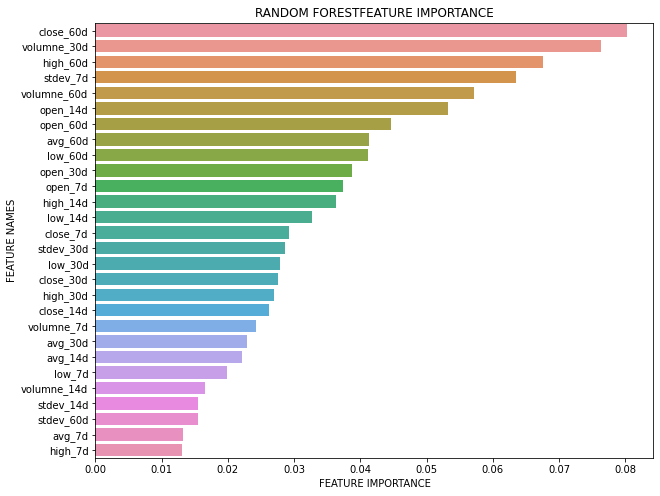

In [144]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance( model.feature_importances_, cols_ft,'RANDOM FOREST' )

In [145]:
infer_df = get_infer_dataset(df.iloc[250:292])

In [146]:
model.predict(infer_df)

array([-0.01199628, -0.02131207, -0.04005049, -0.029321  , -0.01741599,
       -0.00529398, -0.03104969, -0.04277152, -0.04910896, -0.06973069,
       -0.06940453, -0.0593603 , -0.0005    , -0.02952182, -0.03224043,
       -0.03367703, -0.01266925, -0.04620818, -0.03671303, -0.0583165 ,
       -0.02024354, -0.02887524,  0.00093735,  0.01013767])

TF

In [147]:
nn = tf.keras.Sequential([
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(20, activation='relu'),
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='linear'),
])

nn.compile( optimizer= 'adam', loss= 'mse', metrics= ['mae'])

In [148]:
nn.fit(train_df[ cols_ft ], train_df[label], epochs= 50, batch_size= 64, validation_data= ( valid_df[ cols_ft ], valid_df[label] ))

Epoch 1/50
9/9 [==============================] - 1s 21ms/step - loss: 0.5104 - mae: 0.4718 - val_loss: 1.0367 - val_mae: 0.7032
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 0.2683 - mae: 0.3324 - val_loss: 0.5455 - val_mae: 0.5053
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1274 - mae: 0.2322 - val_loss: 0.2839 - val_mae: 0.3595
Epoch 4/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0681 - mae: 0.1737 - val_loss: 0.1605 - val_mae: 0.2717
Epoch 5/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0427 - mae: 0.1460 - val_loss: 0.1076 - val_mae: 0.2245
Epoch 6/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0356 - mae: 0.1350 - val_loss: 0.0862 - val_mae: 0.2017
Epoch 7/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0327 - mae: 0.1298 - val_loss: 0.0751 - val_mae: 0.1890
Epoch 8/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0299 - mae: 0.1241 - val_loss: 

In [149]:
# Train set evaluation
y_true = train_df[label].values
y_pred = nn.predict( train_df[cols_ft] ).reshape(y_true.shape)

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

-0.03939837390971479
0.06700849517845549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528
0,-0.092982,-0.050725,-0.064632,-0.127240,-0.061372,-0.022222,0.058491,0.057514,0.127820,0.168317,0.176015,0.181298,0.176583,0.244353,-0.182692,-0.178030,-0.240642,-0.245614,-0.330000,-0.350000,-0.342105,-0.365913,-0.331974,-0.315182,-0.032941,-0.089862,-0.088028,-0.106977,-0.044776,-0.053455,-0.072500,-0.080255,-0.101343,-0.139759,-0.136253,-0.129114,-0.131274,-0.072917,-0.075521,-0.005510,...,0.168317,0.125000,0.108796,0.070136,0.097950,0.119159,0.093023,0.195238,0.221963,0.191441,0.122881,0.164530,0.139875,0.200846,0.128631,0.135699,0.165957,0.101594,0.034417,0.018904,0.003774,-0.007339,0.014652,-0.045775,-0.007353,-0.062500,-0.032847,-0.081374,-0.031423,-0.025974,0.007519,0.011091,-0.014440,-0.003690,0.000000,0.070588,0.026415,0.049213,0.022901,0.043810
1,-0.010237,-0.031395,0.012479,-0.075439,-0.038500,-0.044302,0.000153,0.009488,-0.089160,0.011830,0.023859,0.002284,-0.006875,-0.072323,-0.064108,-0.110034,-0.273413,-0.090623,-0.197766,-0.034302,-0.099244,0.012479,-0.034304,0.012479,0.043341,-0.066055,-0.029904,0.018279,0.058777,-0.016341,-0.034249,-0.015210,0.043889,0.012836,0.012842,-0.018813,-0.051441,0.009180,-0.074938,0.079478,...,0.060096,0.100617,0.012479,0.062907,0.012479,0.020337,0.009177,0.012479,-0.015903,0.059185,0.323154,0.072327,0.135978,0.086429,0.115874,0.052330,0.036596,-0.024607,0.070373,0.054848,0.053215,-0.073683,0.135795,-0.002927,-0.108731,-0.080953,-0.055493,-0.020110,-0.209061,0.048836,0.103349,-0.033270,0.012856,-0.057489,0.009036,-0.021625,-0.084777,-0.054437,-0.004189,-0.077059
2,-0.082746,-0.019329,-0.077111,-0.051801,-0.022872,0.022080,0.058337,0.048026,0.216980,0.156487,0.152156,0.179014,0.183458,0.316676,-0.118584,-0.067996,0.032771,-0.154991,-0.132234,-0.315698,-0.242861,-0.378392,-0.297670,-0.327661,-0.076282,-0.023807,-0.058124,-0.125255,-0.103554,-0.037114,-0.038251,-0.065044,-0.145232,-0.152595,-0.149095,-0.110301,-0.079833,-0.082096,-0.000583,-0.084988,...,0.108221,0.024383,0.096317,0.007229,0.085471,0.098822,0.083847,0.182759,0.237866,0.132256,-0.200273,0.092203,0.003896,0.114417,0.012757,0.083369,0.129361,0.126200,-0.035956,-0.035944,-0.049442,0.066343,-0.121143,-0.042847,0.101378,0.018453,0.022646,-0.061264,0.177638,-0.074810,-0.095830,0.044361,-0.027296,0.053799,-0.009036,0.092213,0.111192,0.103650,0.027090,0.120869
3,0.889905,0.381064,1.193080,0.407109,0.372683,-0.993594,0.997381,0.835032,1.697547,0.929716,0.864447,0.987404,1.038933,1.295978,0.649092,0.381937,-0.136182,0.631035,0.400708,0.901994,0.709901,1.034104,0.896667,1.039593,2.315711,0.264929,0.660294,1.170864,2.312695,0.694306,0.527607,0.810475,1.433075,1.091843,1.094251,0.854294,0.608141,1.125891,0.007719,15.425298,...,0.642961,0.195061,0.885298,0.103069,0.872597,0.829326,0.901352,0.936083,1.071649,0.690843,-1.629806,0.560403,0.027856,0.569676,0.099172,0.614368,0.779486,1.242208,-1.044734,-1.901440,-13.102014,-9.039241,-8.267986,0.936047,-13.787382,-0.295242,-0.689451,0.752872,-5.653074,2.880184,-12.745421,3.999861,1.890269,-14.579521,-inf,1.306351,4.209402,2.106161,1.182912,2.758962


In [150]:
# Valid set evaluation
y_true = valid_df[label]
y_pred = nn.predict( valid_df[cols_ft] ).reshape(y_true.shape)

print(r2_score(y_true, y_pred))
mae = np.mean( np.abs(y_pred - y_true) )
print(mae)
pd.DataFrame([np.array(y_true), y_pred, y_true - y_pred, (y_true - y_pred)/y_true])

-5.065072245210505
0.127463299481694


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226
0,0.029851,0.005484,0.010989,0.050000,0.038889,0.031136,0.020221,0.037523,0.041045,0.023723,0.036232,0.038182,0.014493,-0.008818,0.001783,0.001776,-0.032432,-0.061483,-0.019713,-0.224599,-0.227273,-0.239930,-0.182143,-0.181495,-0.142349,-0.147163,-0.098696,-0.063584,-0.113346,0.117241,0.108597,0.110599,0.061135,0.050000,0.006224,0.002079,0.006198,0.020576,0.012371,-0.004115,...,0.010799,0.040773,0.040297,0.054545,0.060086,0.088009,0.096667,0.072511,0.105832,0.078579,0.132479,0.123711,0.113150,0.172414,0.157895,0.112235,0.142857,0.112008,0.099609,0.117764,0.096226,0.097248,0.086081,0.027682,0.062937,0.145455,0.099291,0.137931,0.092362,0.096429,0.065404,0.060201,0.114671,0.121212,0.078947,0.038095,0.087097,0.081340,0.086179,0.092834
1,-0.240754,-0.080444,-0.160621,-0.041334,0.012479,-0.151870,0.012479,0.012479,-0.172147,0.012479,0.004769,0.012479,0.012479,-0.074512,0.012479,0.012479,-0.100618,-0.079216,-0.140476,0.002229,-0.086609,-0.011326,-0.101355,0.012479,0.012479,0.012479,0.194513,-0.111558,-0.172897,-0.033749,-0.008317,-0.020326,0.021620,-0.021000,0.076117,0.038375,-0.025680,0.011181,0.012479,0.011378,...,0.004283,-0.016727,0.012479,0.012479,0.012479,-0.069669,0.026779,-0.151260,-0.030811,0.012479,0.025316,0.122850,0.012479,-0.017397,-0.013352,0.020394,0.004976,0.063489,0.146663,-0.085982,-0.210878,-0.147580,0.173666,0.157207,-0.145304,-0.091934,0.005684,0.054260,-0.078970,0.030183,-0.001670,-0.019797,-0.025104,-0.045127,-0.103892,0.035498,-0.129026,-0.048860,0.006712,-0.023037
2,0.270604,0.085929,0.171610,0.091334,0.026410,0.183005,0.007741,0.025044,0.213192,0.011244,0.031463,0.025703,0.002014,0.065693,-0.010697,-0.010703,0.068186,0.017733,0.120763,-0.226828,-0.140664,-0.228604,-0.080787,-0.193974,-0.154828,-0.159642,-0.293209,0.047975,0.059552,0.150990,0.116914,0.130925,0.039515,0.071000,-0.069893,-0.036296,0.031878,0.009396,-0.000108,-0.015493,...,0.006516,0.057499,0.027818,0.042066,0.047607,0.157677,0.069888,0.223770,0.136643,0.066100,0.107162,0.000861,0.100671,0.189810,0.171246,0.091841,0.137881,0.048519,-0.047054,0.203746,0.307104,0.244827,-0.087586,-0.129526,0.208242,0.237389,0.093606,0.083671,0.171333,0.066246,0.067075,0.079998,0.139775,0.166339,0.182839,0.002598,0.216123,0.130200,0.079467,0.115871
3,9.065244,15.667698,15.616552,1.826679,0.679109,5.877702,0.382851,0.667432,5.194132,0.473957,0.868368,0.673166,0.138941,-7.449619,-6.000781,-6.025739,-2.102387,-0.288426,-6.125970,1.009925,0.618922,0.952794,0.443538,1.068757,1.087666,1.084798,2.970819,-0.754509,-0.525399,1.287860,1.076587,1.183782,0.646357,1.420004,-11.229425,-17.458345,5.143022,0.456623,-0.008728,3.764853,...,0.603353,1.410247,0.690321,0.771216,0.792312,1.791610,0.722979,3.086028,1.291135,0.841190,0.808903,0.006962,0.889712,1.100900,1.084560,0.818295,0.965167,0.433178,-0.472382,1.730114,3.191475,2.517564,-1.017485,-4.679120,3.308726,1.632046,0.942749,0.606614,1.855006,0.686992,1.025534,1.328856,1.218918,1.372295,2.315961,0.068189,2.481414,1.600691,0.922114,1.248150


WINDOWING THEO MẪU

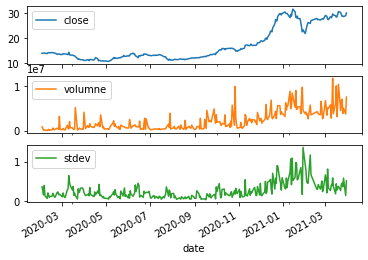

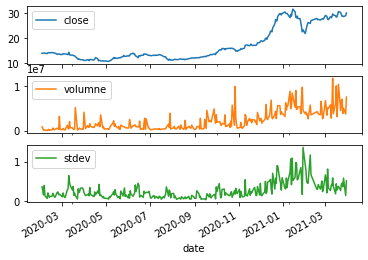

In [ ]:
plot_cols = ['close', 'volumne', 'stdev']
plot_features = data[plot_cols]
plot_features.index = data.index
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:480]
plot_features.index = data.index[:480]
_ = plot_features.plot(subplots=True)

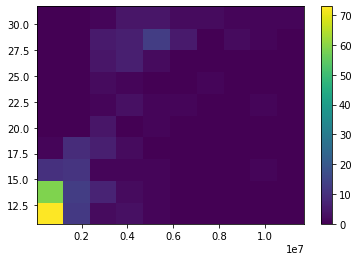

In [ ]:
plt.hist2d(data['volumne'], data['close'], )
plt.colorbar()

In [ ]:
df = data

In [ ]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


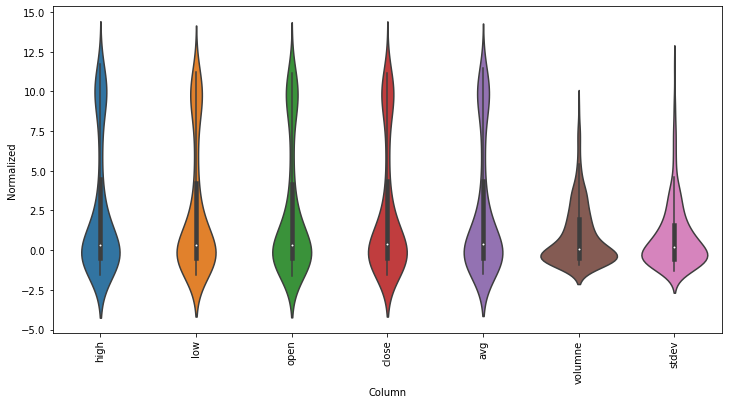

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

InvalidArgumentError: ignored